`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022
 Выполнила: Рудская Ирина
 Вариант №17`




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 

*Данные*: `College_for_lab` (источник: <https://github.com/aksyuk/MTML/blob/main/Labs/data/College_for_lab.csv>)

* `Private` - частный или государственный университет: Yes - частный, No - государственный;
* `Apps` - количество полученных заявок на поступление;
* `Accept` - количество принятых заявок на поступление;
* `Enroll` - количество зачисленных новых студентов;
* `Top10perc` - процент зачисленных студентов, которые в старшей школе относились к топ-10% в классе по успеваемости;
* `Top25perc` - процент зачисленных студентов, которые в старшей школе относились к топ-25% в классе по успеваемости;
* `F_Undergrad` - количество студентов очной формы обучения;
* `P_Undergrad` - количество студентов, обучающихся по совместительству;
* `Outstate` - плата за обучение от студентов, проживающих за пределами штата;
* `Room_Board` - расходы на проживание и питание;
* `Books` - ориентировочная стоимость учебников;
* `Personal` - предполагаемые личные расходы;
* `PhD` - процент преподавателей со степенью доктора философии;
* `Terminal` - процент преподавателей с высшим образованием;
* `S_F_Ratio` - соотношение студентов и преподавателей;
* `perc_alumni` - процент выпускников, которые делают пожертвования колледжу;
* `Expend` - расходы на обучение на одного студента;
* `Grad_Rate` - выпускной балл.

#### Зависимая переменная:
`Grad_Rate`

#### Объясняющие переменные
`Accept`, `Top10perc`, `Private`

# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 17
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
#sns.color_palette("Set2")

### Загружаем данные

Набор данных `insurance` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/College_for_lab.csv>. 

Справочник к данным: <https://github.com/aksyuk/MTML/blob/main/Labs/data/CodeBook_College_for_lab.md>.  

Загружаем данные во фрейм и кодируем категориальные переменные.



In [3]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/College_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (777, 9)


In [4]:
# первые 5 строк фрейма
DF_raw.head(5)

,Grad_Rate,Accept,Top10perc,Top25perc,F_Undergrad,P_Undergrad,PhD,Expend,Private
0,60,1232,23,52,2885,537,70,7041,Yes
1,56,1924,16,29,2683,1227,29,10527,Yes
2,54,1097,22,50,1036,99,53,8735,Yes
3,59,349,60,89,510,63,92,19016,Yes
4,15,146,16,44,249,869,76,10922,Yes


In [5]:
# типы столбцов фрейма
DF_raw.dtypes

Grad_Rate       int64
Accept          int64
Top10perc       int64
Top25perc       int64
F_Undergrad     int64
P_Undergrad     int64
PhD             int64
Expend          int64
Private        object
dtype: object

Проверим, нет ли в таблице пропусков.  

In [6]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Grad_Rate      0
Accept         0
Top10perc      0
Top25perc      0
F_Undergrad    0
P_Undergrad    0
PhD            0
Expend         0
Private        0
dtype: int64

Пропусков не обнаружено.  

In [7]:
# кодируем категориальные переменные
# тип университета
# Yes - частный, No - государственный
Private_dict = {'Yes' : 1, 'No' : 0}
DF_raw['PrivateYes'] = DF_raw.Private.map(Private_dict)

In [8]:
# оставляем в наборе данных только то, что нужно 
DF_all = DF_raw[['Grad_Rate', 'Accept', 'Top10perc', 'PrivateYes']]
DF_all.columns
DF_all.head()

,Grad_Rate,Accept,Top10perc,PrivateYes
0,60,1232,23,1
1,56,1924,16,1
2,54,1097,22,1
3,59,349,60,1
4,15,146,16,1


In [9]:
DF_all.dtypes

Grad_Rate     int64
Accept        int64
Top10perc     int64
PrivateYes    int64
dtype: object

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [10]:
# данные для построения моделей
DF = DF_all.sample(frac = 0.8, random_state = my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

Для проверки выведем несколько строк для данных для построения моделей и для прогнозов.

In [11]:
# данные для построения моделей
DF.head(5)

,Grad_Rate,Accept,Top10perc,PrivateYes
25,48,1729,12,0
481,81,321,28,1
593,91,1798,46,1
56,75,3028,15,0
168,54,329,4,1


In [12]:
# данные для прогонозов
DF_predict.head(5)

,Grad_Rate,Accept,Top10perc,PrivateYes
1,56,1924,16,1
2,54,1097,22,1
5,55,479,38,1
8,80,839,30,1
17,59,908,19,1


## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `Grad_Rate`, которая является зависимой переменной модели, несильно отличается по масштабу от `Top10perc`, а `Accept` отличается от них двоих. Это логично, если обратиться к описанию перемнных.

* `Grad_Rate` - выпускной балл;
* `Top10perc` - процент зачисленных студентов, которые в старшей школе относились к топ-10% в классе по успеваемости;
* `Accept` - количество принятых заявок на поступление.

Очевидно, объясняющая переменная `PrivateYes` принимает нулевые значения, так как она дискретна и ее возможные знаяения - 0 или 1. Остальные показатели положительны.

In [13]:
# описательные статистики для непрерывных переменных
DF[['Grad_Rate', 'Accept', 'Top10perc']].describe()

,Grad_Rate,Accept,Top10perc
count,622.000000,622.000000,622.000000
mean,65.771704,2107.274920,27.824759
std,17.450809,2602.168187,18.406481
min,10.000000,90.000000,1.000000
25%,53.000000,589.750000,15.000000
50%,66.000000,1193.500000,23.000000
75%,78.000000,2569.500000,36.000000
max,118.000000,26330.000000,96.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

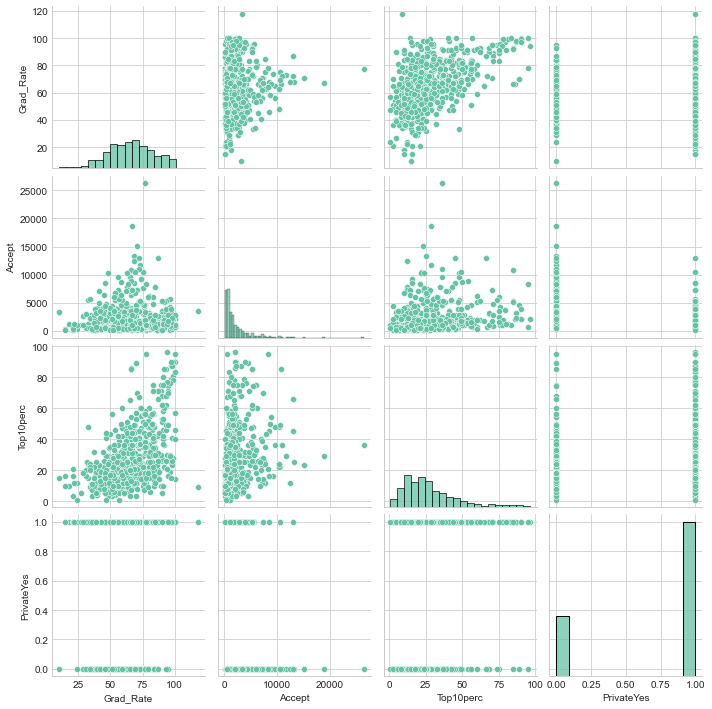

In [14]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Grad_Rate', 'Accept', 'Top10perc', 'PrivateYes']])
plt.show()

Судя по этим графикам:  
* не смотря на близкое к нормальному распределению, распределение зависимой `Grad_Rate` нельзя назвать нормальным;  
* из всех объясняющих только `Top10perc` близка к нормальному, однако распределение так же нельзя назвать нормальным;  
* объясняющая `PrivateYes` дискретна, что очевидно из её смысла: частный или государственный университет;  
* не наблюдается линейной связи между перемннными. 


Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от типа университета.  

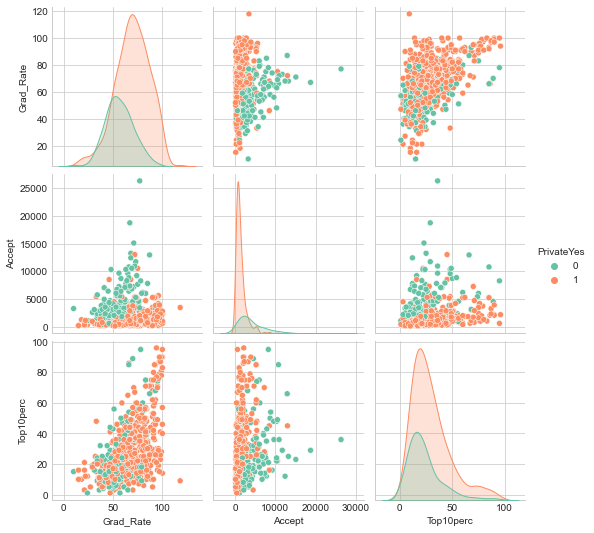

In [15]:
# матричный график разброса с цветом по типу университета
sns.pairplot(DF[['Grad_Rate', 'Accept', 'Top10perc', 'PrivateYes']],
            hue='PrivateYes')
plt.show()

Небольшой вывод относительно графиков на главной диагонали. Пики разных цветов не совпадают, плотности не накладываются друг на друга. Значит, есть влияние этой объясняющей фиктивной переменной на взаимосвязи между непрервными переменными.

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [16]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Grad_Rate,Accept,Top10perc
Grad_Rate,1.00,0.07,0.52
Accept,0.07,1.00,0.20
Top10perc,0.52,0.20,1.00


Посчитаем корреляционные матрицы для частных и государственных университетов.

In [17]:
# корреляционная матрица по классу частных университетов
corr_mat = DF.loc[DF['PrivateYes'] == 1][['Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Grad_Rate,Accept,Top10perc
Grad_Rate,1.00,0.26,0.51
Accept,0.26,1.00,0.35
Top10perc,0.51,0.35,1.00


In [18]:
# корреляционная матрица по классу государственных университетов
corr_mat = DF.loc[DF['PrivateYes'] == 0][['Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Grad_Rate,Accept,Top10perc
Grad_Rate,1.00,0.39,0.49
Accept,0.39,1.00,0.36
Top10perc,0.49,0.36,1.00


На основании корреляционных матриц можно сделать вывод, что выпускной балл достаточно сильно зависит от количество принятых заявок на поступление, если университет является государственным. Если университет частный, то корреляция значительно меньше.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [19]:
# логарифмируем зависимую переменную
DF['log_Grad_Rate'] = np.log(DF['Grad_Rate'])

# описательные статистики для непрерывных показателей
DF[['Grad_Rate', 'Accept', 'Top10perc']].describe()

,Grad_Rate,Accept,Top10perc
count,622.000000,622.000000,622.000000
mean,65.771704,2107.274920,27.824759
std,17.450809,2602.168187,18.406481
min,10.000000,90.000000,1.000000
25%,53.000000,589.750000,15.000000
50%,66.000000,1193.500000,23.000000
75%,78.000000,2569.500000,36.000000
max,118.000000,26330.000000,96.000000


Проведём формальные тесты на нормальность.  

In [20]:
# тестируем на нормальность
for col in ['Grad_Rate', 'log_Grad_Rate']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Grad_Rate Statistics=0.99, p=0.0117
Распределение не нормально (H0 отклоняется)

log_Grad_Rate Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

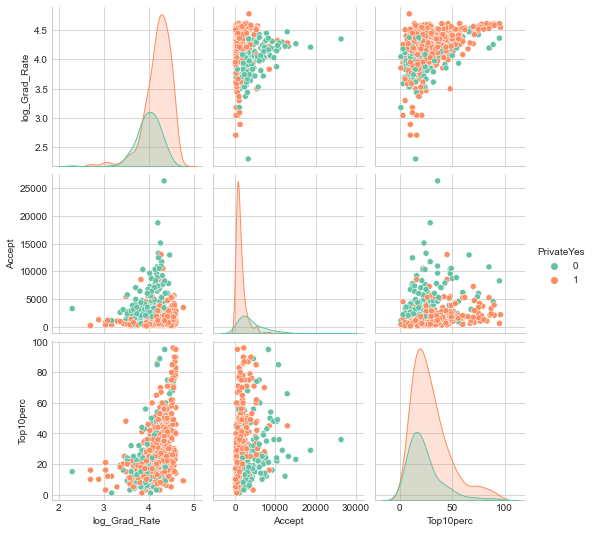

In [21]:
# матричный график разброса с цветом по PrivateYes
sns.pairplot(DF[['log_Grad_Rate','Accept', 'Top10perc', 'PrivateYes']],
            hue='PrivateYes')
plt.show()

После логарифмирования переменная `Grad_Rate` (теперь `log_Grad_Rate`) по-прежнему не распределена нормально, но в некотрых местах есть изменения.

In [22]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['log_Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Grad_Rate,Accept,Top10perc
log_Grad_Rate,1.00,0.08,0.47
Accept,0.08,1.00,0.20
Top10perc,0.47,0.20,1.00


In [23]:
# корреляционная матрица по классу частных университетов
corr_mat = DF.loc[DF['PrivateYes'] == 1][['log_Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Grad_Rate,Accept,Top10perc
log_Grad_Rate,1.00,0.24,0.46
Accept,0.24,1.00,0.35
Top10perc,0.46,0.35,1.00


In [24]:
# корреляционная матрица по классу государственных университетов
corr_mat = DF.loc[DF['PrivateYes'] == 0][['log_Grad_Rate', 'Accept', 'Top10perc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_Grad_Rate,Accept,Top10perc
log_Grad_Rate,1.00,0.36,0.43
Accept,0.36,1.00,0.36
Top10perc,0.43,0.36,1.00


На основании этих корреляционных матриц можно сделать вывод, что связь между `log_Grad_Rate` и `Accept` для частных и государственных университетов стала слабее, чем была до логарифмирования. Поэтому ошибка модели будет больше на обучающей выборке с прологарифмированной зависимой переменной.

## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Accept + \hat{\beta_3} \cdot Top10perc$
2. `fit_lm_2`: $\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Accept \cdot PrivateYes + \hat{\beta_3} \cdot Top10perc$
3. `fit_lm_3`: $\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Top10perc \cdot PrivateYes + \hat{\beta_3} \cdot Accept$
4. `fit_lm_4`: $\hat{Grad\_Rate} = \hat{\beta_0} + \hat{\beta_1} \cdot PrivateYes + \hat{\beta_2} \cdot Top10perc \cdot PrivateYes + \hat{\beta_3} \cdot Accept \cdot PrivateYes$

5. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_Grad\_Rate}$  
6. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_Grad\_Rate}$
7. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_Grad\_Rate}$
8. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_Grad\_Rate}$

Кроме того, добавим в сравнение модели зависимости `Grad_Rate` и `log_Grad_Rate` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [26]:
# данные для моделей 1, 5
df1 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Top10perc']]

# данные для моделей 2, 6
df2 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Top10perc']]
df2.loc[:, 'Accept_PrivateYes'] = df2.loc[:, 'Accept'] * df2.loc[:, 'PrivateYes']
df2 = df2.drop(['Accept'], axis=1)

# данные для моделей 3, 7
df3 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Top10perc']]
df3.loc[:, 'Top10perc_PrivateYes'] = df3.loc[:, 'Top10perc'] * df3.loc[:, 'PrivateYes'] 
df3 = df3.drop(['Top10perc'], axis=1)

# данные для моделей 4, 8
df4 = DF[['Grad_Rate', 'PrivateYes', 'Accept', 'Top10perc']]
df4.loc[:, 'Accept_PrivateYes'] = df4.loc[:, 'Accept_PrivateYes'] = df4.loc[:, 'Accept'] * df4.loc[:, 'PrivateYes']
df4.loc[:, 'Top10perc_PrivateYes'] = df4.loc[:, 'Top10perc_PrivateYes'] = df4.loc[:, 'Top10perc'] * df4.loc[:, 'PrivateYes'] 
df4 = df4.drop(['Accept', 'Top10perc'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_Grad_Rate'], axis=1)

Проверка результатов.

In [27]:
df0.head(5)

,Grad_Rate,Accept,Top10perc,PrivateYes
25,48,1729,12,0
481,81,321,28,1
593,91,1798,46,1
56,75,3028,15,0
168,54,329,4,1


In [28]:
df3.head(5)

,Grad_Rate,PrivateYes,Accept,Top10perc_PrivateYes
25,48,0,1729,0
481,81,1,321,28
593,91,1,1798,46
56,75,0,3028,0
168,54,1,329,4


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `Grad_Rate` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [29]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['Grad_Rate'], axis=1)
y = df0.Grad_Rate.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [42.683] 
 объясняющие  ['Accept', 'Top10perc', 'PrivateYes'] 
 коэффициенты  [[1.0000e-03 4.2000e-01 1.3108e+01]]


In [30]:
# оценим MSE на обучающей
# прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([14.02463777])

С интрпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [31]:
# модель со всеми объясняющими, y_log
X = df0.drop(['Grad_Rate'], axis=1)
y = np.log(df0.Grad_Rate).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [3.769] 
 объясняющие  ['Accept', 'Top10perc', 'PrivateYes'] 
 коэффициенты  [[0.    0.007 0.214]]


In [32]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[ 0. ,  0.7, 23.9]])

In [33]:
# оценим MSE на обучающей
# прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([14.26585905])

In [35]:
print('MSE_train модели для Grad_Rate меньше MSE_train',
     'модели для log(Grad_Rate) в ', np.around(MSE_log / MSE, 3), 'раз')

MSE_train модели для Grad_Rate меньше MSE_train модели для log(Grad_Rate) в  [1.035] раз


Так происходит, так как корреляция стала меньше для объясняющих переменных и прологарифмированной зависимой.

### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [36]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Grad_Rate'], axis=1)
    y = df.Grad_Rate
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 14.62 секунд


In [37]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Grad_Rate'], axis=1)
    y = np.log(df.Grad_Rate)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 17.88 секунд


Сравним ошибки для моделей на исходных значениях `Grad_Rate` с ошибками моделей на логарифме.  

In [38]:
# для проверки
scores

[-198.82235316963454,
 -198.82235316963457,
 -201.70068158399715,
 -206.31881419872968,
 -215.2773040938098]

In [39]:
[np.around(-x, 2) for x in scores]

[198.82, 198.82, 201.7, 206.32, 215.28]

In [40]:
[np.around(-x, 3) for x in scores_log]

[0.067, 0.067, 0.068, 0.07, 0.073]

Определим самые точные модели отдельно на `Grad_Rate` и на `Grad_Rate`.  

In [41]:
# самая точная на Grad_Rate
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 199.0


In [42]:
# самая точная на log(Grad_Rate)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_1_log :
MSE_loocv = 0.067


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [43]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Grad_Rate'], axis=1)
    y = df.Grad_Rate
    kf_10 =  KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)    
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.26 секунд


In [44]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Grad_Rate'], axis=1)
    y = np.log(df.Grad_Rate)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.25 секунд


Сравним ошибки для моделей на исходных значениях `Grad_Rate` с ошибками моделей на логарифме.  

In [45]:
# для проверки
scores

[-198.06466937266515,
 -198.6978708962285,
 -201.35770056121277,
 -206.31454494289773,
 -215.5358474659002]

In [46]:
[np.around(-x, 2) for x in scores]

[198.06, 198.7, 201.36, 206.31, 215.54]

In [47]:
[np.around(-x, 3) for x in scores_log]

[0.067, 0.067, 0.068, 0.07, 0.072]

Определим самые точные модели отдельно на `Grad_Rate` и на `log(Grad_Rate)`.  

In [48]:
# самая точная на Grad_Rate
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 198.0


In [49]:
# самая точная на log(Grad_Rate)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 0.067


Можно убедиться, что оценка MSE методом перекрёстной проверки по 10 блокам даёт результаты, практически идентичные методу LOOCV. При этом скорость у второго метода значительно быстрее. 

Самой точной среди моделей для `Grad_Rate` оказалась `fit_lm_0`, а среди моделей для `Grad_Rate_log` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [50]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['Grad_Rate'], axis=1)
y = df0.Grad_Rate.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Grad_Rate']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Grad_Rate'], axis=1)
#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 205.27


In [51]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['Grad_Rate'], axis=1)
y = np.log(df0.Grad_Rate).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['Grad_Rate']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Grad_Rate'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 205.47


In [52]:
np.around(np.sqrt(MSE) / np.mean(DF_predict[['Grad_Rate']]) * 100, 1)

Grad_Rate    22.3
dtype: float64

In [53]:
np.around(np.sqrt(MSE_log) / np.mean(DF_predict[['Grad_Rate']]) * 100, 1)

Grad_Rate    22.3
dtype: float64

Модели похожи между собой,  но на выборке для прогноза чуть точнее модель `fit_lm_0`.

In [54]:
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 5),
      '\n объясняющие ', list(df0.drop(['Grad_Rate'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 5))

модель fit_lm_0:
 константа  [3.76937] 
 объясняющие  ['Accept', 'Top10perc', 'PrivateYes'] 
 коэффициенты  [[2.0000e-05 6.6100e-03 2.1424e-01]]


## Вывод:

$ Y = 3,76937 + 0,00002 \cdot Accept + 0,00661 \cdot Top10perc + 0,21424 \cdot PrivateYes $

* Ошибка модели на отложенных наблюдениях составила 22.3% от среднего значения `Y`.
* При объясняющих переменных, равных 0, `Y` равен константе 3,76937.
* При увеличении `Accept` на единицу, `Y` увеличится на 0,00002. При увеличении `Top10perc` на единицу, `Y` увеличится на 0,00661. При значении дискретной переменной `PrivateYes` = 1, `Y` увеличится на 0,21424.

Проверим нашу модель на выборке.

In [55]:
DF_predict.head(10)

,Grad_Rate,Accept,Top10perc,PrivateYes
1,56,1924,16,1
2,54,1097,22,1
5,55,479,38,1
8,80,839,30,1
17,59,908,19,1
21,70,4664,20,0
26,88,1700,23,1
30,69,725,21,1
31,71,798,42,1
32,48,556,16,1


In [56]:
y_pred = fit_lm_0.predict(X[:10])
np.exp(y_pred)

array([[61.75052163],
       [63.32405756],
       [69.6299172 ],
       [66.46157168],
       [61.87531298],
       [53.69581482],
       [64.42146441],
       [62.49793233],
       [71.89650302],
       [60.28719031]])

## Вывод:
Модель довольно близко спрогназировала значения.

# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  